<a href="https://colab.research.google.com/github/Shubham07102003/Weather-Trend-Forecasting/blob/main/Weather_Forecasting_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weather Trend Forecasting for PM Accelerator

**Assignment** Weather Trend Forecasting using the Global Weather Repository dataset

**Author** Your Name

**Date** 2025-08-31

The Product Manager Accelerator Program is designed to support PM professionals through every stage of their careers. From students looking for entry-level jobs to Directors looking to take on a leadership role, our program has helped over hundreds of students fulfill their career aspirations.

Our Product Manager Accelerator community are ambitious and committed. Through our program they have learnt, honed and developed new PM and leadership skills, giving them a strong foundation for their future endeavors.

In [12]:
# Standard imports
import os
import gc
import math
import json
import warnings
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Stats and models
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# Try to import statsmodels for SARIMAX, fall back gracefully if unavailable
try:
    import statsmodels.api as sm
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    HAS_STATSMODELS = True
except Exception as e:
    HAS_STATSMODELS = False
    print("statsmodels not available, SARIMAX step will be skipped.")

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10, 5)

DATA_PATH = "/content/GlobalWeatherRepository.csv"
RANDOM_STATE = 42

# Parameters you can adjust
PICK_TOP_N_CITIES = 20          # explore among the most recorded cities
TARGET_COL = "temperature_celsius"
TIME_COL = "last_updated"
CITY_COL = "location_name"
COUNTRY_COL = "country"
LAT_COL = "latitude"
LON_COL = "longitude"

FORECAST_HORIZON_DAYS = 14      # forecast next two weeks
VALIDATION_DAYS = 60            # keep the last N days for validation

In [13]:

def memory_optimize(df):
    # Downcast numeric columns to reduce memory
    for col in df.select_dtypes(include=["int64", "int32"]).columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")
    for col in df.select_dtypes(include=["float64", "float32"]).columns:
        df[col] = pd.to_numeric(df[col], downcast="float")
    return df

def add_time_parts(frame, time_col: str):
    f = frame.copy()
    f["year"] = f[time_col].dt.year
    f["month"] = f[time_col].dt.month
    f["day"] = f[time_col].dt.day
    f["dayofweek"] = f[time_col].dt.dayofweek
    f["weekofyear"] = f[time_col].dt.isocalendar().week.astype(int)
    f["dayofyear"] = f[time_col].dt.dayofyear
    f["is_weekend"] = f["dayofweek"].isin([5, 6]).astype(int)
    return f

def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    lo = s.quantile(lower_q)
    hi = s.quantile(upper_q)
    return s.clip(lower=lo, upper=hi)

def temporal_train_valid_split(ts_df, time_col: str, valid_days: int):
    last_time = ts_df[time_col].max()
    split_time = last_time - pd.Timedelta(days=valid_days)
    train = ts_df[ts_df[time_col] <= split_time].copy()
    valid = ts_df[ts_df[time_col] > split_time].copy()
    return train, valid

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0

def seasonal_naive_forecast(series, season: int, steps: int):
    # Repeat the last season pattern
    last_season = series.iloc[-season:]
    reps = math.ceil(steps / season)
    forecast = np.tile(last_season.values, reps)[:steps]
    return forecast

def build_lag_features(df, target: str, lags=(1, 2, 3, 7, 14), rolls=(3, 7, 14)):
    f = df.copy()
    for L in lags:
        f[f"{target}_lag_{L}"] = f[target].shift(L)
    for R in rolls:
        f[f"{target}_rollmean_{R}"] = f[target].rolling(R).mean()
        f[f"{target}_rollstd_{R}"] = f[target].rolling(R).std()
    return f


## Load and preview

In [14]:
# Load data
raw = pd.read_csv(DATA_PATH)

# Parse time
raw[TIME_COL] = pd.to_datetime(raw[TIME_COL], errors="coerce")
raw = raw.dropna(subset=[TIME_COL])

# Basic cleanup
raw = raw.drop_duplicates()
raw = memory_optimize(raw)

# Keep only rows where coordinates and target exist
for c in [COUNTRY_COL, CITY_COL, LAT_COL, LON_COL, TIME_COL, TARGET_COL]:
    if c not in raw.columns:
        raise ValueError(f"Required column missing {c}")

df = raw.copy()

print("Rows", len(df), "Columns", len(df.columns))
print("Time range", df[TIME_COL].min(), "to", df[TIME_COL].max())
print("Unique cities", df[CITY_COL].nunique(), "Unique countries", df[COUNTRY_COL].nunique())

# Identify numeric columns for analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Show missingness summary
missing_summary = df.isna().mean().sort_values(ascending=False).head(20)
print("Top missingness share")
print(missing_summary)

Rows 40146 Columns 41
Time range 2024-05-16 01:45:00 to 2024-12-09 23:45:00
Unique cities 248 Unique countries 210
Top missingness share
country                   0.0
location_name             0.0
latitude                  0.0
longitude                 0.0
timezone                  0.0
last_updated_epoch        0.0
last_updated              0.0
temperature_celsius       0.0
temperature_fahrenheit    0.0
condition_text            0.0
wind_mph                  0.0
wind_kph                  0.0
wind_degree               0.0
wind_direction            0.0
pressure_mb               0.0
pressure_in               0.0
precip_mm                 0.0
precip_in                 0.0
humidity                  0.0
cloud                     0.0
dtype: float64


## Data cleaning plan

The goal is to keep as much information as possible while removing the obvious errors.

1 Normalize time based on the reported timezone using the given time column

2 Handle missing values for core numeric signals with robust imputations grouped by city whenever possible and global median as a backstop

3 Clip extreme outliers by capping numeric columns at the first and ninety ninth percentile to reduce the impact of rare recording spikes

4 Standardize text labels such as wind direction

5 Create tidy types for downstream modeling

In [15]:
df_clean = df.copy()

# Standardize text columns where present
if "wind_direction" in df_clean.columns:
    df_clean["wind_direction"] = df_clean["wind_direction"].astype(str).str.upper().str.strip()

# Winsorize numeric columns to reduce extreme outliers
for c in numeric_cols:
    df_clean[c] = winsorize_series(df_clean[c])

# Impute missing numeric values per city when possible else global median
city_groups = df_clean.groupby(CITY_COL)
for c in numeric_cols:
    medians_by_city = city_groups[c].transform("median")
    df_clean[c] = df_clean[c].fillna(medians_by_city)
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())

# Remove any remaining rows without coordinates or target
df_clean = df_clean.dropna(subset=[LAT_COL, LON_COL, TARGET_COL])
df_clean = df_clean.sort_values([CITY_COL, TIME_COL]).reset_index(drop=True)

print("After cleaning", df_clean.shape)

After cleaning (40146, 41)


## Exploratory analysis

I will focus on the few main points for this:

1 Which cities and countries are most represented

2 How do temperature and precipitation move over time

3 How do weather and air quality interact

4 Which features move together



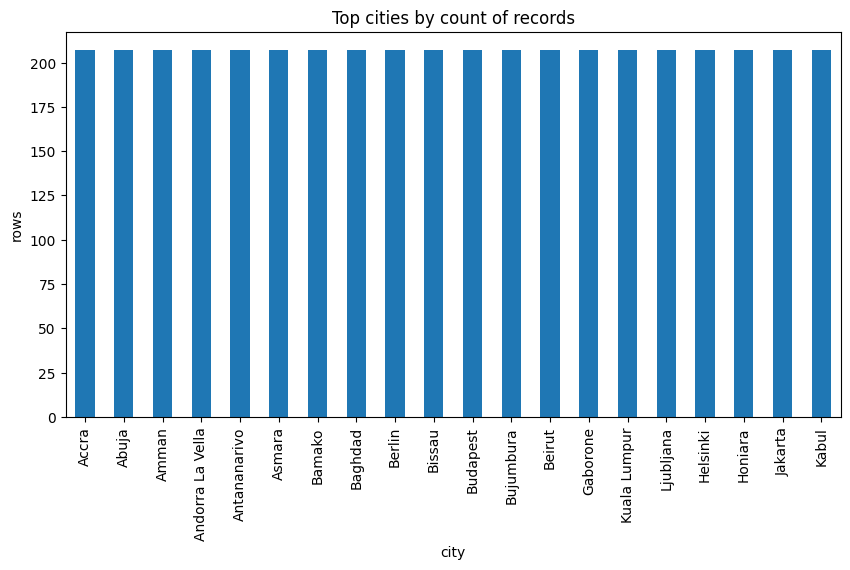

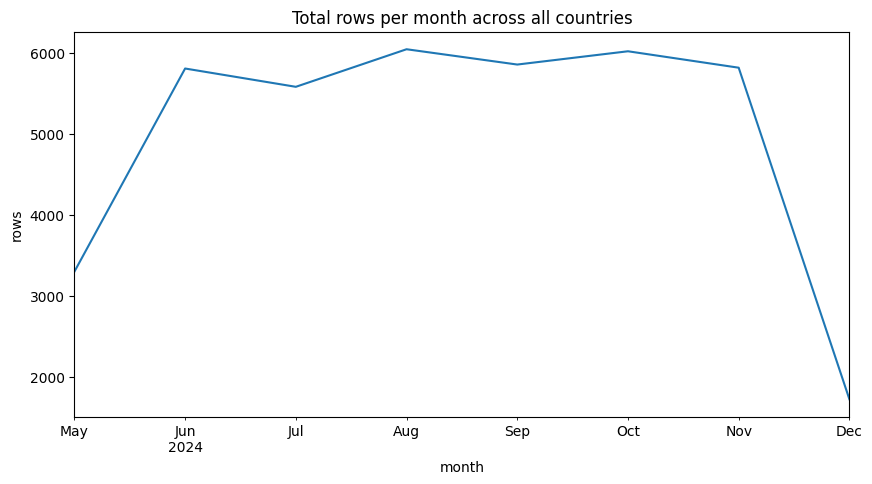

In [16]:
# Top cities by coverage
city_counts = df_clean[CITY_COL].value_counts().head(20)
city_counts.plot(kind="bar")
plt.title("Top cities by count of records")
plt.xlabel("city")
plt.ylabel("rows")
plt.show()

# Time coverage by country sampled monthly
monthly_country = (
    df_clean[[COUNTRY_COL, TIME_COL]]
    .assign(month=lambda x: x[TIME_COL].dt.to_period("M").dt.to_timestamp())
    .groupby([COUNTRY_COL, "month"])
    .size()
    .reset_index(name="rows")
)
pivot_country = monthly_country.pivot(index="month", columns=COUNTRY_COL, values="rows").fillna(0)
pivot_country.sum(axis=1).plot()
plt.title("Total rows per month across all countries")
plt.xlabel("month")
plt.ylabel("rows")
plt.show()

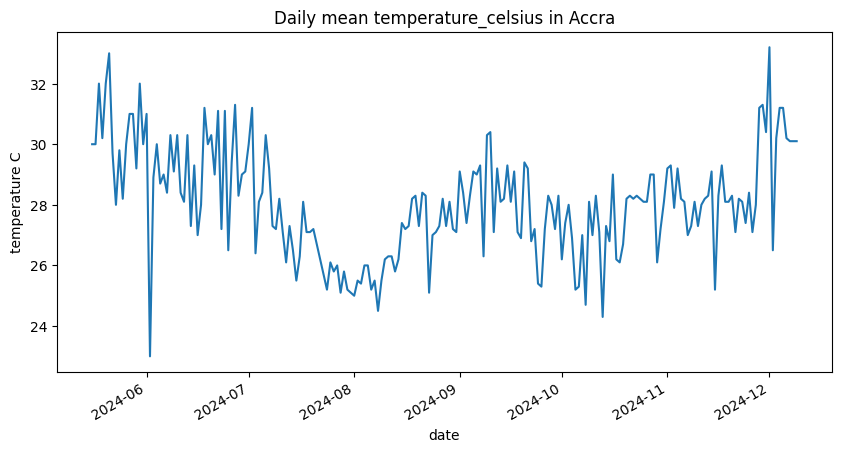

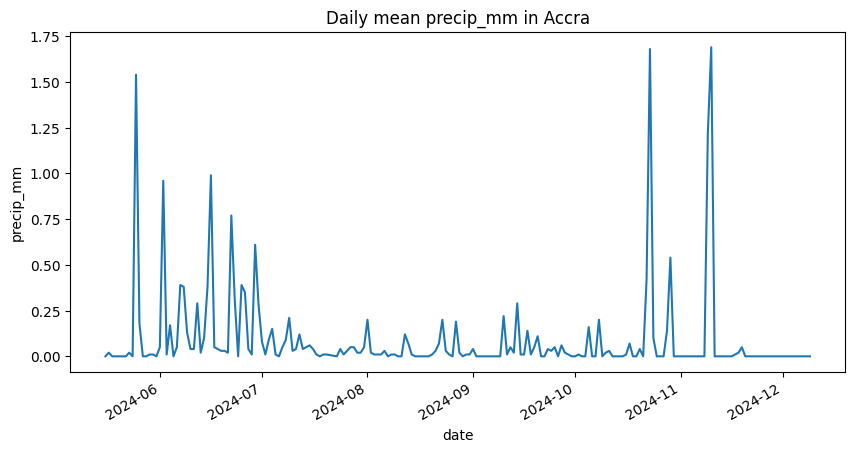

In [17]:
# Temperature over time for the single most covered city
top_city = df_clean[CITY_COL].value_counts().index[0]
city_df = df_clean[df_clean[CITY_COL] == top_city].copy()
daily_city = city_df.set_index(TIME_COL).resample("D")[TARGET_COL].mean().dropna()

daily_city.plot()
plt.title(f"Daily mean {TARGET_COL} in {top_city}")
plt.xlabel("date")
plt.ylabel("temperature C")
plt.show()

# Precipitation visualization if present
precip_cols = [c for c in df_clean.columns if "precip" in c.lower() or "rain" in c.lower()]
if len(precip_cols) > 0:
    precip_col = precip_cols[0]
    daily_precip = city_df.set_index(TIME_COL).resample("D")[precip_col].mean().dropna()
    daily_precip.plot()
    plt.title(f"Daily mean {precip_col} in {top_city}")
    plt.xlabel("date")
    plt.ylabel(precip_col)
    plt.show()
else:
    print("No precipitation column detected explicitly. Skipping plot.")

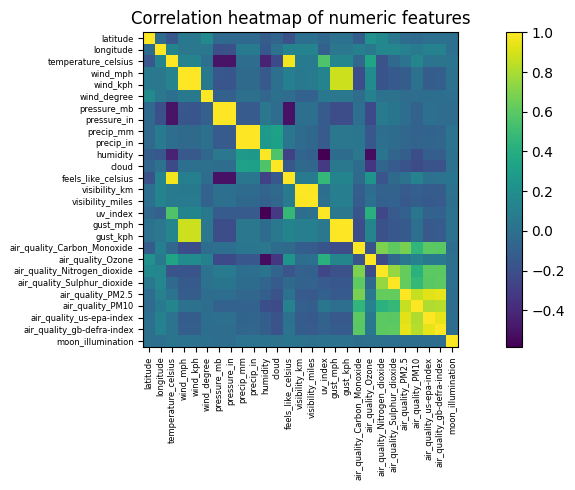

In [18]:
# Correlation snapshot on selected numeric features
num_for_corr = [c for c in numeric_cols if "epoch" not in c and "fahrenheit" not in c]
corr = df_clean[num_for_corr].sample(min(20000, len(df_clean))).corr()

plt.imshow(corr.values, interpolation="nearest")
plt.title("Correlation heatmap of numeric features")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=6)
plt.colorbar()
plt.tight_layout()
plt.show()

## Air quality vs weather

The dataset contains several air quality fields like PM two point five PM ten ozone nitrogen dioxide and sulphur dioxide indices. We will check simple relationships with temperature and humidity

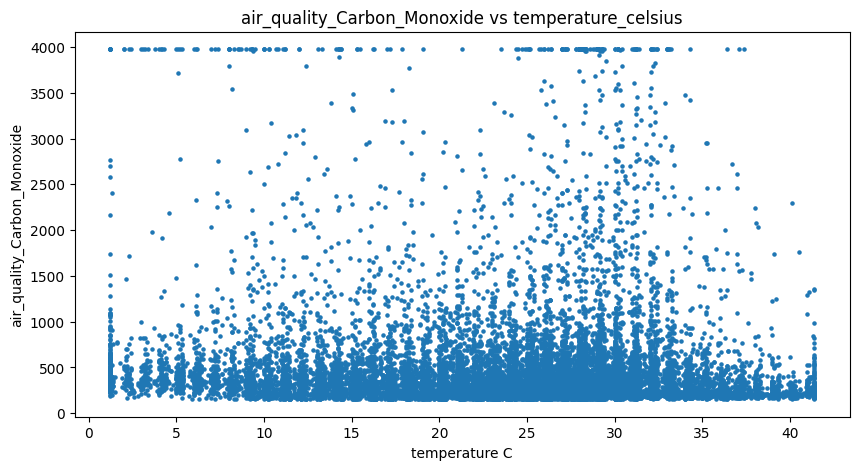

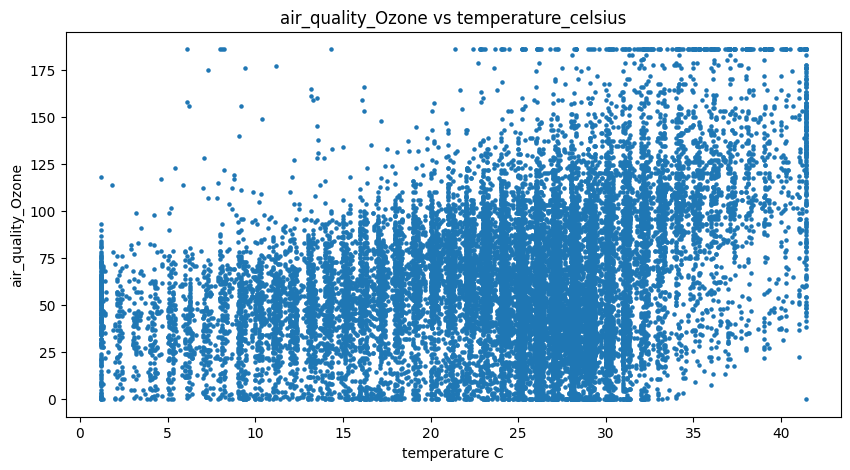

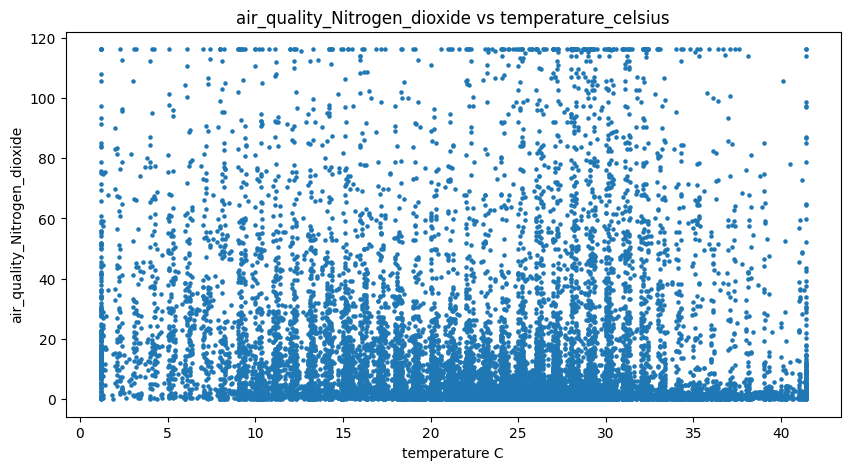

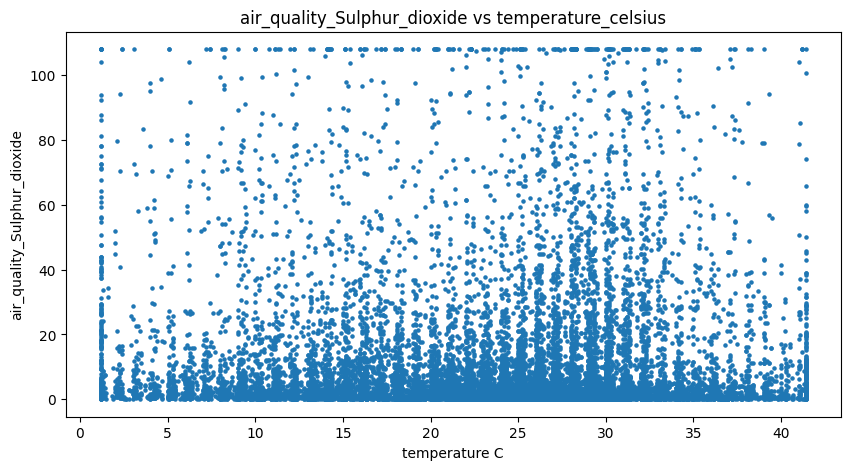

In [19]:
aq_cols = [c for c in df_clean.columns if c.lower().startswith("air_quality")]
pairs = []
for c in aq_cols:
    if c in df_clean.columns and df_clean[c].notna().sum() > 1000:
        pairs.append((c, df_clean[c].astype(float)))

if len(pairs) > 0 and TARGET_COL in df_clean:
    sample = df_clean[[TARGET_COL] + [p[0] for p in pairs]].dropna().sample(min(20000, df_clean.shape[0]), random_state=RANDOM_STATE)
    for cname, _ in pairs[:4]:
        plt.scatter(sample[TARGET_COL], sample[cname], s=5)
        plt.title(f"{cname} vs {TARGET_COL}")
        plt.xlabel("temperature C")
        plt.ylabel(cname)
        plt.show()
else:
    print("Air quality columns sparse. Skipping this section.")

## Spatial patterns

A simple way to see geography is to scatter average temperature and humidity over latitude and longitude. For clarity we summarize by city

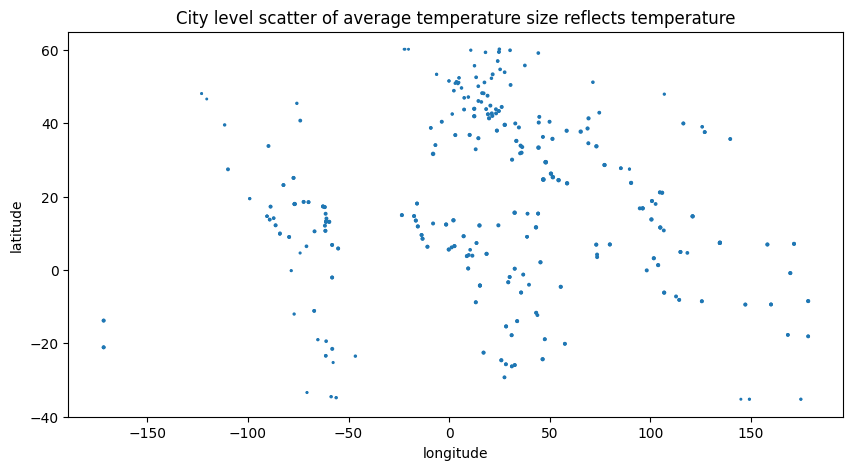

In [20]:
agg = (
    df_clean.groupby([COUNTRY_COL, CITY_COL, LAT_COL, LON_COL], as_index=False)
    .agg(avg_temp=(TARGET_COL, "mean"),
         avg_humidity=("humidity", "mean") if "humidity" in df_clean.columns else (TARGET_COL, "mean"))
)

plt.scatter(agg[LON_COL], agg[LAT_COL], s=5* (agg["avg_temp"] - agg["avg_temp"].min() + 1) / (agg["avg_temp"].max() - agg["avg_temp"].min() + 1))
plt.title("City level scatter of average temperature size reflects temperature")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

## Anomaly detection

We will flag unusual observations using Isolation Forest. The model runs per city to respect local climate norms. The outlier score helps spotlight sudden temperature jumps or drops and inconsistent sensor values

Share of flagged outliers across top cities 0.014


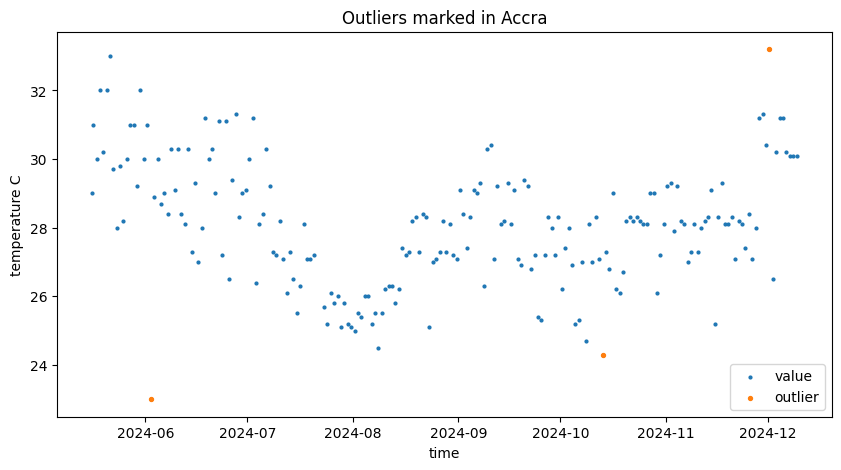

In [21]:
anomaly_results = []

features_for_anom = [TARGET_COL]
for cand in ["humidity", "wind_kph", "pressure_mb"]:
    if cand in df_clean.columns:
        features_for_anom.append(cand)

cities = df_clean[CITY_COL].value_counts().index[:PICK_TOP_N_CITIES]

for city in cities:
    sub = df_clean[df_clean[CITY_COL] == city][[TIME_COL] + features_for_anom].dropna()
    if len(sub) < 200:
        continue
    X = sub[features_for_anom].astype(float).values
    clf = IsolationForest(n_estimators=200, contamination=0.01, random_state=RANDOM_STATE)
    scores = clf.fit_predict(X)
    sub = sub.copy()
    sub["is_outlier"] = (scores == -1).astype(int)
    sub["city"] = city
    anomaly_results.append(sub)

if len(anomaly_results) > 0:
    anom_df = pd.concat(anomaly_results).sort_values(TIME_COL)
    share = anom_df["is_outlier"].mean()
    print(f"Share of flagged outliers across top cities {share:.3f}")
    # Visualize for top city
    cdf = anom_df[anom_df["city"] == top_city].copy()
    plt.scatter(cdf[TIME_COL], cdf[TARGET_COL], s=4, label="value")
    plt.scatter(cdf.loc[cdf["is_outlier"] == 1, TIME_COL], cdf.loc[cdf["is_outlier"] == 1, TARGET_COL], s=8, label="outlier")
    plt.title(f"Outliers marked in {top_city}")
    plt.xlabel("time")
    plt.ylabel("temperature C")
    plt.legend()
    plt.show()
else:
    print("Not enough data per city to run anomaly detection.")

## Forecasting

We will build and compare multiple models on the most covered city by record count. The target is daily temperature in celsius

Models
1 Naive last

2 Seasonal naive with a seven day cycle

3 Random Forest on lag features and calendar

4 SARIMAX if the library is available

We keep the last chunk of days as validation and report MAE RMSE and MAPE. Finally we average the models to form a simple ensemble

Validation metrics
naive {'MAE': 1.6216665506362915, 'RMSE': 2.058680957778351, 'MAPE': 5.5502190589904785, 'R2': -0.7577261924743652}
seasonal_naive {'MAE': 2.244999885559082, 'RMSE': 2.775758271963717, 'MAPE': 7.727181911468506, 'R2': -2.1954824924468994}
rf {'MAE': 0.7136388899485271, 'RMSE': 0.9782389524190394, 'MAPE': 2.5187856142772027, 'R2': 0.6031164300812304}
sarimax {'MAE': 1.935700331487204, 'RMSE': 2.3689596145912195, 'MAPE': 6.6262551398310094, 'R2': -1.3274937884900182}
ensemble_mean {'MAE': 1.5618727981071758, 'RMSE': 1.9076710685730207, 'MAPE': 5.362094658448494, 'R2': -0.5093160945788633}


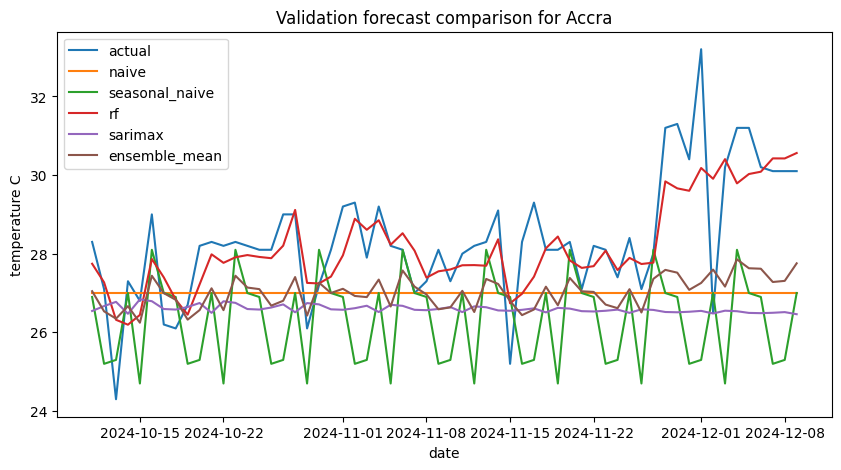

Best model by RMSE rf


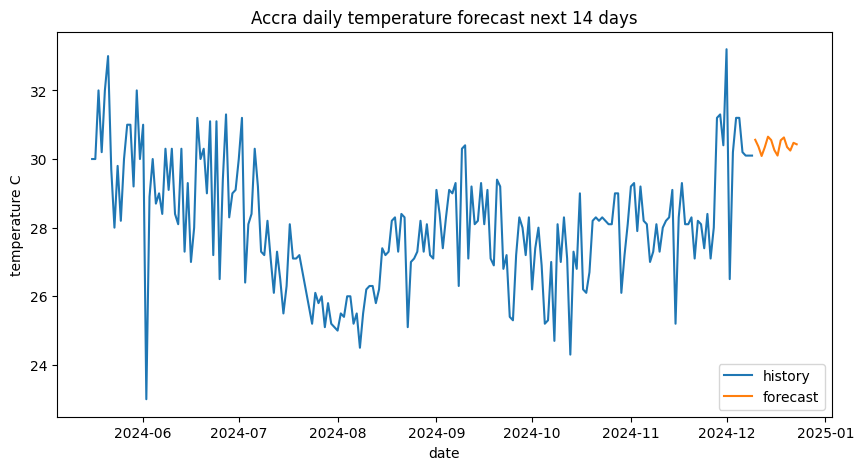

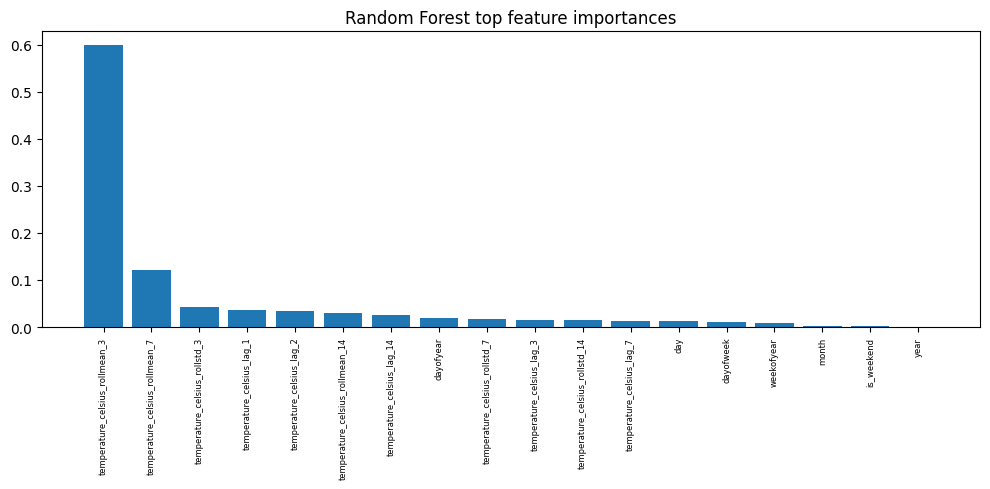

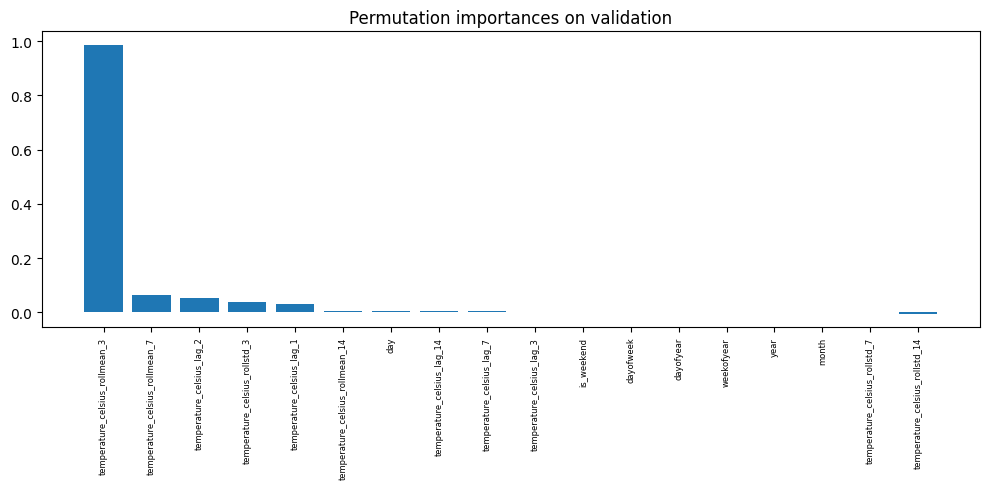

In [22]:
# Pick the top city by record count
city = top_city
city_frame = df_clean[df_clean[CITY_COL] == city].copy()

# Build a daily series
daily = city_frame.set_index(TIME_COL).resample("D").agg({TARGET_COL:"mean"}).dropna().reset_index()
daily = add_time_parts(daily, TIME_COL)

# Train and validation split
train, valid = temporal_train_valid_split(daily, TIME_COL, VALIDATION_DAYS)

y_train = train[TARGET_COL].values
y_valid = valid[TARGET_COL].values

# Container for predictions
preds = {}

# Model 1 naive
preds["naive"] = np.repeat(train[TARGET_COL].iloc[-1], len(valid))

# Model 2 seasonal naive weekly
if len(train) >= 7:
    preds["seasonal_naive"] = seasonal_naive_forecast(train[TARGET_COL], season=7, steps=len(valid))

# Model 3 Random Forest with lags
fe = build_lag_features(daily[[TIME_COL, TARGET_COL]].set_index(TIME_COL), TARGET_COL, lags=(1,2,3,7,14), rolls=(3,7,14)).reset_index()
fe = add_time_parts(fe, TIME_COL)
fe = fe.dropna()

train_fe, valid_fe = temporal_train_valid_split(fe, TIME_COL, VALIDATION_DAYS)
X_train = train_fe.drop(columns=[TARGET_COL, TIME_COL]).values
X_valid = valid_fe.drop(columns=[TARGET_COL, TIME_COL]).values
y_train_fe = train_fe[TARGET_COL].values
y_valid_fe = valid_fe[TARGET_COL].values

rf = RandomForestRegressor(n_estimators=300, max_depth=None, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train_fe)
rf_pred = rf.predict(X_valid)
preds["rf"] = rf_pred

# Optional Model 4 SARIMAX
if HAS_STATSMODELS and len(train) > 100:
    try:
        sarimax = SARIMAX(train[TARGET_COL], order=(2,0,2), seasonal_order=(1,0,1,7), enforce_stationarity=False, enforce_invertibility=False)
        sarimax_fit = sarimax.fit(disp=False)
        sar_pred = sarimax_fit.forecast(steps=len(valid))
        preds["sarimax"] = sar_pred.values if hasattr(sar_pred, "values") else np.array(sar_pred)
    except Exception as e:
        print("SARIMAX training failed", str(e))

# Evaluate
metrics = {}
for name, yhat in preds.items():
    metrics[name] = {
        "MAE": float(mean_absolute_error(y_valid, yhat)),
        "RMSE": float(rmse(y_valid, yhat)),
        "MAPE": float(mape(y_valid, yhat)),
        "R2": float(r2_score(y_valid, yhat))
    }

# Ensemble average of available models
ens_pred = np.mean(np.column_stack([p for p in preds.values()]), axis=1)
metrics["ensemble_mean"] = {
    "MAE": float(mean_absolute_error(y_valid, ens_pred)),
    "RMSE": float(rmse(y_valid, ens_pred)),
    "MAPE": float(mape(y_valid, ens_pred)),
    "R2": float(r2_score(y_valid, ens_pred))
}

print("Validation metrics")
for m, vals in metrics.items():
    print(m, vals)

# Visual comparison
plt.plot(valid[TIME_COL], y_valid, label="actual")
for name, yhat in preds.items():
    plt.plot(valid[TIME_COL], yhat, label=name)
plt.plot(valid[TIME_COL], ens_pred, label="ensemble_mean")
plt.title(f"Validation forecast comparison for {city}")
plt.xlabel("date")
plt.ylabel("temperature C")
plt.legend()
plt.show()

# Train on full history and make next two weeks forecast with the top model by RMSE
best_model = min(metrics.items(), key=lambda kv: kv[1]["RMSE"])[0]
print("Best model by RMSE", best_model)

last_date = daily[TIME_COL].max()
future_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=FORECAST_HORIZON_DAYS, freq="D")

if best_model in ["naive", "seasonal_naive"]:
    if best_model == "naive":
        future_pred = np.repeat(daily[TARGET_COL].iloc[-1], FORECAST_HORIZON_DAYS)
    else:
        future_pred = seasonal_naive_forecast(daily[TARGET_COL], season=7, steps=FORECAST_HORIZON_DAYS)
elif best_model == "rf":
    full_fe = build_lag_features(daily[[TIME_COL, TARGET_COL]].set_index(TIME_COL), TARGET_COL, lags=(1,2,3,7,14), rolls=(3,7,14))
    full_fe = add_time_parts(full_fe.reset_index(), TIME_COL).dropna()
    # walk forward to produce predictions
    history = daily.copy()
    preds_future = []
    for step in range(FORECAST_HORIZON_DAYS):
        temp_fe = build_lag_features(history[[TIME_COL, TARGET_COL]].set_index(TIME_COL), TARGET_COL, lags=(1,2,3,7,14), rolls=(3,7,14)).reset_index()
        temp_fe = add_time_parts(temp_fe, TIME_COL).dropna()
        X_last = temp_fe.drop(columns=[TARGET_COL, TIME_COL]).values[-1:]
        y_next = rf.predict(X_last)[0]
        preds_future.append(y_next)
        # append to history
        next_time = history[TIME_COL].max() + pd.Timedelta(days=1)
        history = pd.concat([history, pd.DataFrame({TIME_COL:[next_time], TARGET_COL:[y_next]})], ignore_index=True)
    future_pred = np.array(preds_future)
elif best_model == "sarimax" and HAS_STATSMODELS:
    future_pred = sarimax_fit.forecast(steps=FORECAST_HORIZON_DAYS).values
else:
    # default to ensemble mean walk forward using rf when available
    future_pred = np.repeat(daily[TARGET_COL].iloc[-1], FORECAST_HORIZON_DAYS)

forecast_df = pd.DataFrame({TIME_COL: future_index, f"{TARGET_COL}_forecast": future_pred})
plt.plot(daily[TIME_COL], daily[TARGET_COL], label="history")
plt.plot(forecast_df[TIME_COL], forecast_df[f"{TARGET_COL}_forecast"], label="forecast")
plt.title(f"{city} daily temperature forecast next {FORECAST_HORIZON_DAYS} days")
plt.xlabel("date")
plt.ylabel("temperature C")
plt.legend()
plt.show()

# Feature importance for RF model if used
if "rf" in preds:
    importances = rf.feature_importances_
    feat_names = train_fe.drop(columns=[TARGET_COL, TIME_COL]).columns
    order = np.argsort(importances)[::-1][:20]
    plt.bar(range(len(order)), importances[order])
    plt.xticks(range(len(order)), [feat_names[i] for i in order], rotation=90, fontsize=6)
    plt.title("Random Forest top feature importances")
    plt.tight_layout()
    plt.show()

    # permutation importance for more reliable ranking on validation
    perm = permutation_importance(rf, X_valid, y_valid_fe, n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1)
    order_p = np.argsort(perm.importances_mean)[::-1][:20]
    plt.bar(range(len(order_p)), perm.importances_mean[order_p])
    plt.xticks(range(len(order_p)), [feat_names[i] for i in order_p], rotation=90, fontsize=6)
    plt.title("Permutation importances on validation")
    plt.tight_layout()
    plt.show()

# Advanced section



## Seasonal shape and trend

Let's choose the best-covered city and break down its daily temperature into three parts: trend, seasonal rhythm, and leftover noise. If statsmodels is available, we will use seasonal decomposition.

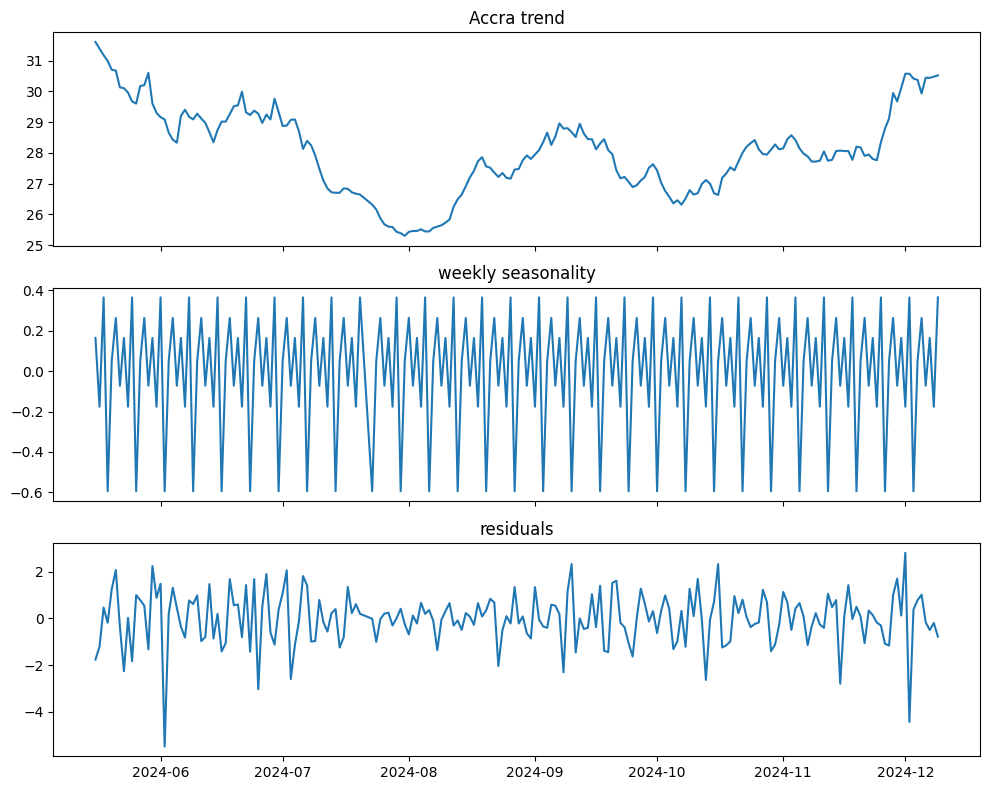

In [23]:
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    HAS_DECOMP = True
except Exception:
    HAS_DECOMP = False
    print("seasonal_decompose not available")

city = df_clean[CITY_COL].value_counts().index[0]
s = (df_clean[df_clean[CITY_COL] == city]
     .set_index(TIME_COL)
     [TARGET_COL]
     .resample("D").mean()
     .dropna())

if HAS_DECOMP and len(s) > 200:
    res = seasonal_decompose(s, model="additive", period=7, extrapolate_trend="freq")
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    axes[0].plot(res.trend); axes[0].set_title(f"{city} trend")
    axes[1].plot(res.seasonal); axes[1].set_title("weekly seasonality")
    axes[2].plot(res.resid); axes[2].set_title("residuals")
    plt.tight_layout(); plt.show()
else:
    print("Skipping decomposition due to short series or missing library.")

## Outliers detection second way

We already flagged unusual readings with Isolation Forest. Here is a second lens that checks rolling z scores inside each city. The goal is to catch both sudden jumps and slow drifts.

Share of rolling z score outliers 0.007


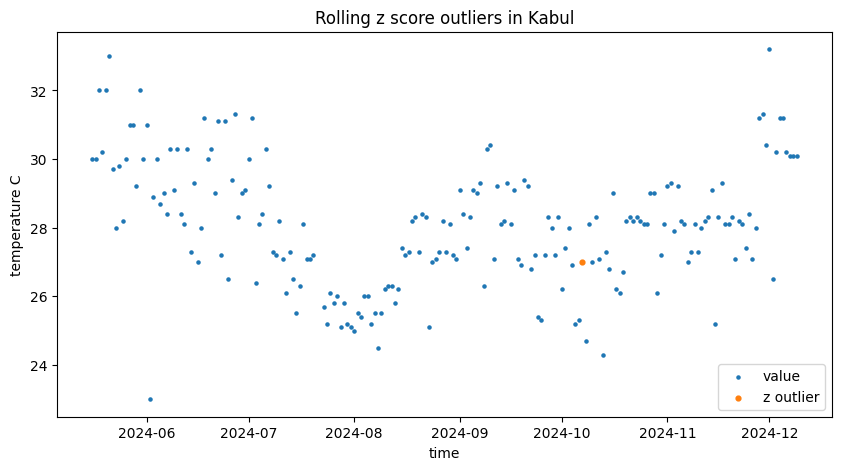

In [24]:
import numpy as np

def rolling_zscores(v, win=21):
    m = v.rolling(win, min_periods=max(5, win//3)).mean()
    sd = v.rolling(win, min_periods=max(5, win//3)).std()
    return (v - m) / sd

z_anoms = []
for city in df_clean[CITY_COL].value_counts().index[:PICK_TOP_N_CITIES]:
    sub = (df_clean[df_clean[CITY_COL]==city]
           .set_index(TIME_COL)[TARGET_COL]
           .resample("D").mean().dropna())
    if len(sub) < 60:
        continue
    z = rolling_zscores(sub, win=21)
    flags = (np.abs(z) > 3).astype(int)
    tmp = flags.to_frame("z_outlier").reset_index()
    tmp["city"] = city
    z_anoms.append(tmp)

if z_anoms:
    zdf = pd.concat(z_anoms, ignore_index=True)
    print("Share of rolling z score outliers",
          zdf["z_outlier"].mean().round(3))
    # quick look for top city
    ztop = zdf[zdf["city"]==city].merge(
        s.reset_index().rename(columns={TARGET_COL:"temp"}),
        on=TIME_COL, how="left"
    )
    plt.scatter(ztop[TIME_COL], ztop["temp"], s=5, label="value")
    plt.scatter(ztop.loc[ztop["z_outlier"]==1, TIME_COL],
                ztop.loc[ztop["z_outlier"]==1, "temp"],
                s=12, label="z outlier")
    plt.title(f"Rolling z score outliers in {city}")
    plt.xlabel("time"); plt.ylabel("temperature C"); plt.legend(); plt.show()

## Climate patterns across regions



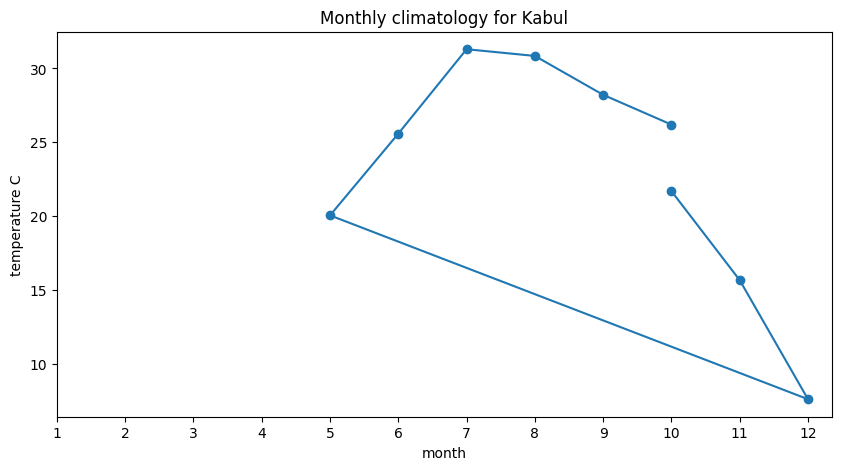

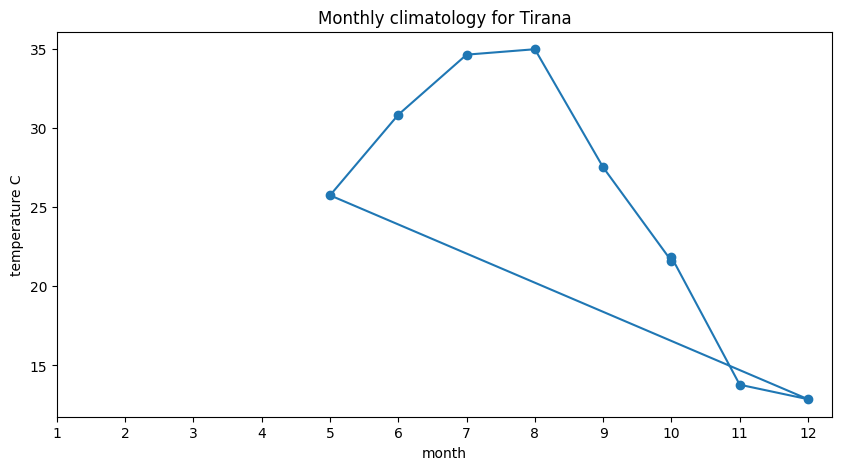

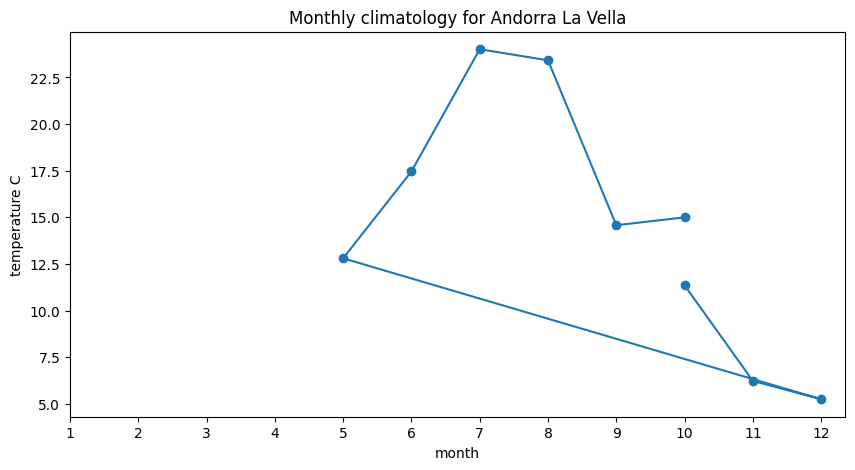

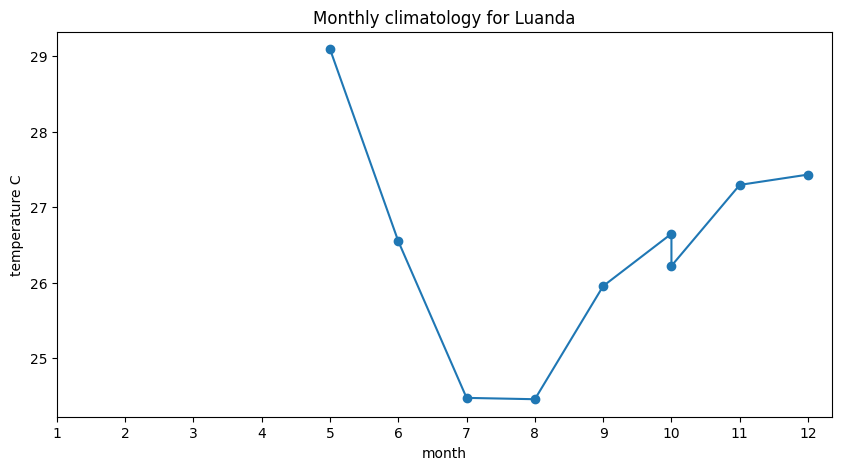

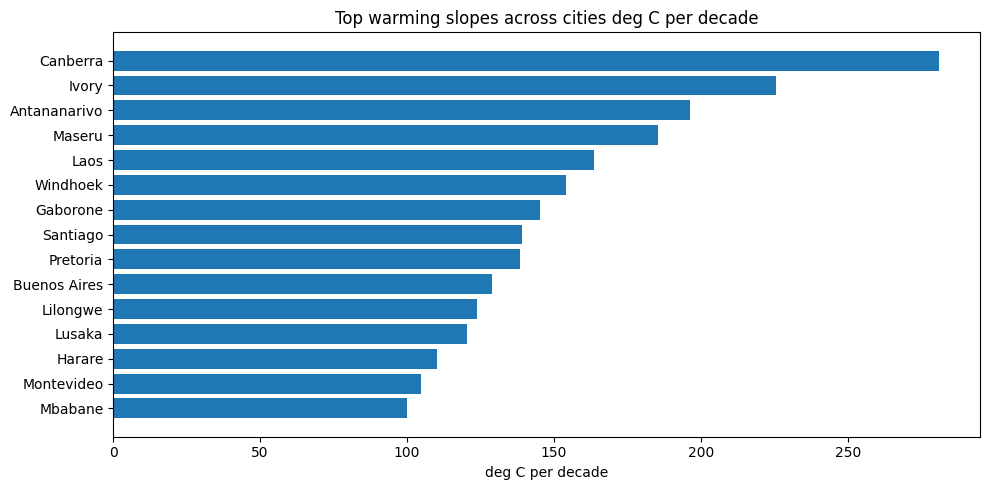

In [25]:
# Derive month and year, then build a tidy panel
panel = df_clean[[COUNTRY_COL, CITY_COL, LAT_COL, LON_COL, TIME_COL, TARGET_COL]].copy()
panel["year"] = panel[TIME_COL].dt.year
panel["month"] = panel[TIME_COL].dt.month
daily = (panel
         .set_index(TIME_COL)
         .groupby([COUNTRY_COL, CITY_COL, LAT_COL, LON_COL])
         [TARGET_COL].resample("D").mean().dropna().reset_index())

# Monthly climatology by city
daily["month"] = daily[TIME_COL].dt.month
clim = (daily.groupby([COUNTRY_COL, CITY_COL, LAT_COL, LON_COL, "month"], as_index=False)
        [TARGET_COL].mean()
        .rename(columns={TARGET_COL:"climatology"}))

# Visualize a few sample cities to show seasonal curve
sample_cities = daily[CITY_COL].value_counts().index[:4]
for cty in sample_cities:
    row = clim[clim[CITY_COL]==cty]
    plt.plot(row["month"], row["climatology"], marker="o")
    plt.title(f"Monthly climatology for {cty}")
    plt.xlabel("month"); plt.ylabel("temperature C"); plt.xticks(range(1,13)); plt.show()

# Simple linear trend per city in deg C per decade
from sklearn.linear_model import LinearRegression
trend_rows = []
for (cc, cty), g in daily.groupby([COUNTRY_COL, CITY_COL]):
    s = g[[TIME_COL, TARGET_COL]].dropna().copy()
    if len(s) < 200:
        continue
    # numeric time in years
    t = (s[TIME_COL] - s[TIME_COL].min()).dt.total_seconds() / (365.25*24*3600)
    X = t.values.reshape(-1,1)
    y = s[TARGET_COL].values
    reg = LinearRegression().fit(X, y)
    slope_per_year = reg.coef_[0]
    trend_rows.append({COUNTRY_COL: cc, CITY_COL: cty, "slope_C_per_decade": slope_per_year*10})

trends = pd.DataFrame(trend_rows)
if not trends.empty:
    trends = trends.sort_values("slope_C_per_decade", ascending=False)
    head = trends.head(15)
    plt.barh(head[CITY_COL], head["slope_C_per_decade"])
    plt.gca().invert_yaxis()
    plt.title("Top warming slopes across cities deg C per decade")
    plt.xlabel("deg C per decade"); plt.tight_layout(); plt.show()

## Continents and latitude bands

We group countries into continents and cities into latitude bands so that we can quickly compare climates.  This is a rough but useful way to look at things for the first time.

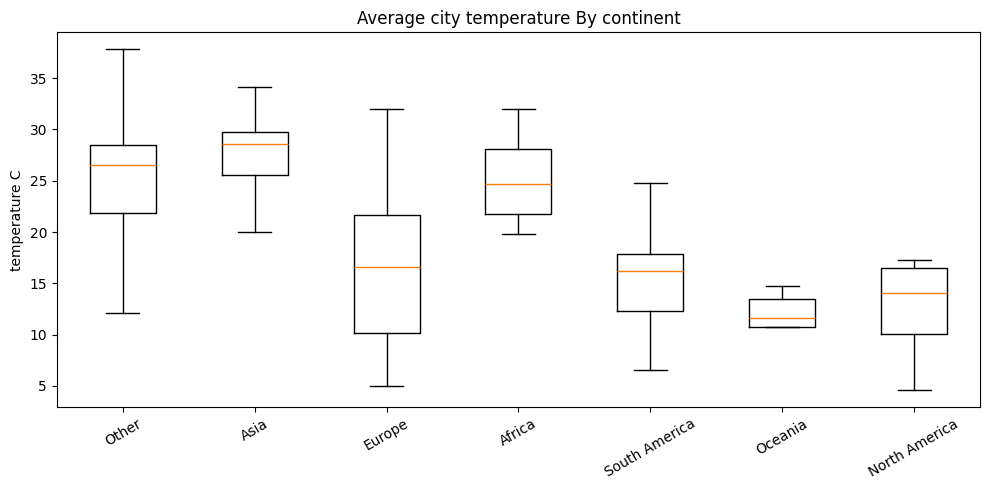

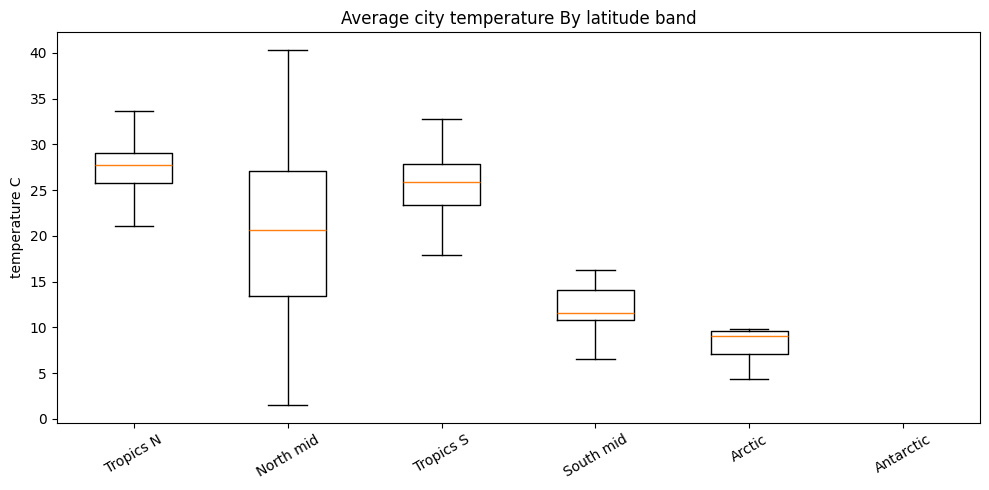

In [26]:
# Lightweight country to continent mapping for common entries in the dataset.
continent_map = {
    "United States":"North America","USA":"North America","Canada":"North America","Mexico":"North America",
    "Brazil":"South America","Argentina":"South America","Chile":"South America","Peru":"South America","Colombia":"South America",
    "United Kingdom":"Europe","UK":"Europe","France":"Europe","Germany":"Europe","Italy":"Europe","Spain":"Europe","Netherlands":"Europe","Poland":"Europe","Sweden":"Europe","Norway":"Europe","Switzerland":"Europe",
    "Russia":"Europe","Ukraine":"Europe","Portugal":"Europe","Greece":"Europe","Ireland":"Europe","Belgium":"Europe","Denmark":"Europe","Finland":"Europe","Czechia":"Europe","Czech Republic":"Europe",
    "India":"Asia","China":"Asia","Japan":"Asia","South Korea":"Asia","Indonesia":"Asia","Malaysia":"Asia","Thailand":"Asia","Vietnam":"Asia","Bangladesh":"Asia","Pakistan":"Asia","Sri Lanka":"Asia","Nepal":"Asia","Singapore":"Asia","Philippines":"Asia","Saudi Arabia":"Asia","United Arab Emirates":"Asia","Israel":"Asia","Turkey":"Asia",
    "Australia":"Oceania","New Zealand":"Oceania",
    "South Africa":"Africa","Egypt":"Africa","Kenya":"Africa","Nigeria":"Africa","Morocco":"Africa","Ethiopia":"Africa","Ghana":"Africa","Tunisia":"Africa"
}

geo = (df_clean[[COUNTRY_COL, CITY_COL, LAT_COL, LON_COL, TARGET_COL]]
       .groupby([COUNTRY_COL, CITY_COL, LAT_COL, LON_COL], as_index=False)
       .agg(avg_temp=(TARGET_COL,"mean")))

geo["continent"] = geo[COUNTRY_COL].map(continent_map).fillna("Other")
geo["lat_band"] = pd.cut(geo[LAT_COL], bins=[-90,-60,-30,0,30,60,90],
                         labels=["Antarctic","South mid","Tropics S","Tropics N","North mid","Arctic"])

# Boxplots by continent and latitude band
for col, title in [("continent","By continent"),("lat_band","By latitude band")]:
    order = geo[col].value_counts().index.tolist()
    data = [geo.loc[geo[col]==val,"avg_temp"].values for val in order]
    plt.boxplot(data, labels=order, showfliers=False)
    plt.title(f"Average city temperature {title}")
    plt.xticks(rotation=30); plt.ylabel("temperature C"); plt.tight_layout(); plt.show()

## Spatial density map



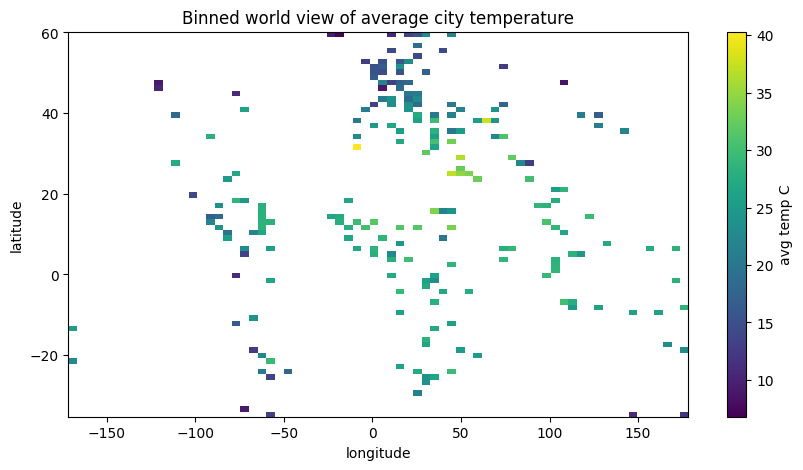

In [27]:
# Two dimensional binned heat map of average temperature
import numpy as np
bins = 72  # about five degree bins
H, xedges, yedges = np.histogram2d(geo[LON_COL], geo[LAT_COL], bins=bins, weights=geo["avg_temp"])
counts, _, _ = np.histogram2d(geo[LON_COL], geo[LAT_COL], bins=bins)
avg_temp_grid = np.divide(H, counts, out=np.full_like(H, np.nan, dtype=float), where=counts>0)

plt.imshow(avg_temp_grid.T, origin="lower",
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect="auto")
plt.colorbar(label="avg temp C")
plt.title("Binned world view of average city temperature")
plt.xlabel("longitude"); plt.ylabel("latitude"); plt.show()

## Air and weather together
local air indicators like PM two point five PM ten ozone nitrogen dioxide and sulphur dioxide relate to temperature humidity wind and pressure. The goal is pattern spotting.

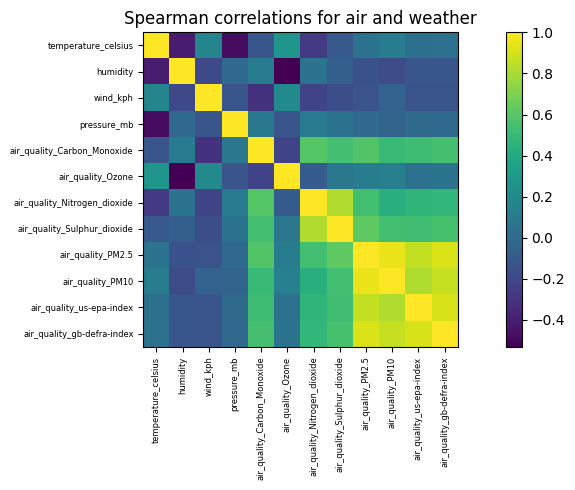

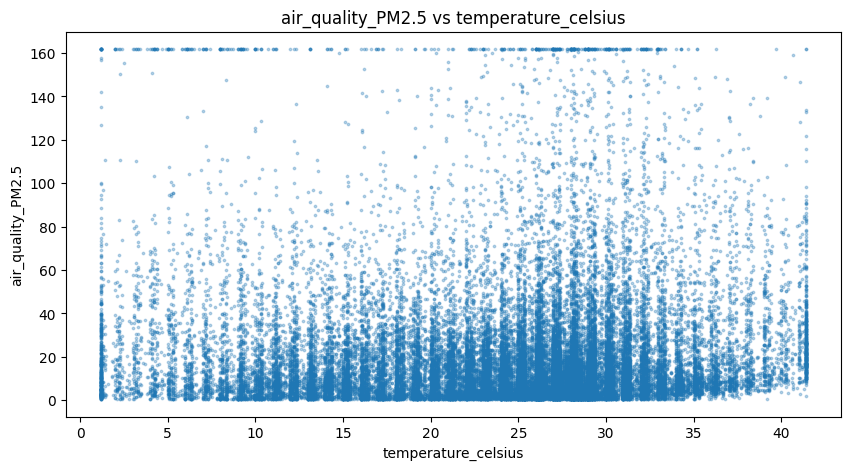

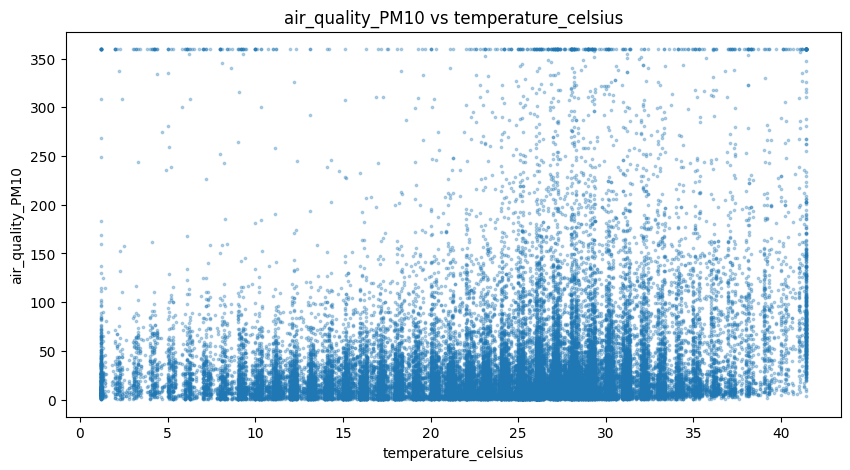

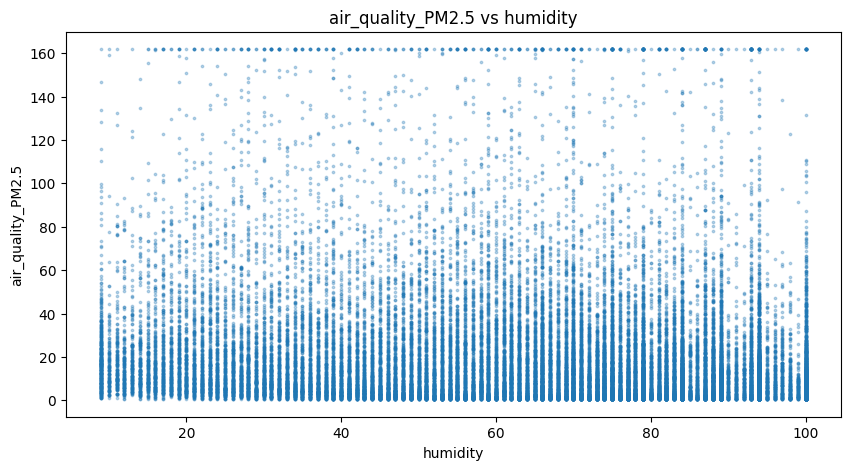

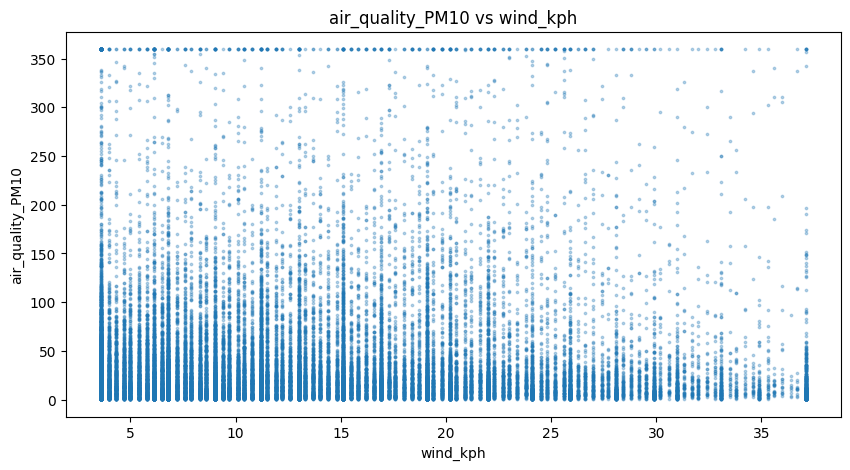

In [28]:
# Select a clean sample with key variables
cand_weather = ["humidity","wind_kph","pressure_mb"]
cand_weather = [c for c in cand_weather if c in df_clean.columns]
aq_cols = [c for c in df_clean.columns if c.startswith("air_quality")]
keep = [TARGET_COL] + cand_weather + aq_cols
sample = df_clean[keep].dropna()
if len(sample) > 60000:
    sample = sample.sample(60000, random_state=RANDOM_STATE)

if not sample.empty:
    # Spearman rank correlations to reduce the pull of outliers
    corr = sample.corr(method="spearman")
    plt.imshow(corr.values, interpolation="nearest")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=6)
    plt.colorbar(); plt.title("Spearman correlations for air and weather"); plt.tight_layout(); plt.show()

    # Simple paired scatter for top few pairs
    show_pairs = [(TARGET_COL, "air_quality_PM2.5"), (TARGET_COL, "air_quality_PM10"),
                  ("humidity", "air_quality_PM2.5") if "humidity" in sample.columns else None,
                  ("wind_kph", "air_quality_PM10") if "wind_kph" in sample.columns else None]
    show_pairs = [p for p in show_pairs if p and p[0] in sample.columns and p[1] in sample.columns]
    for xcol, ycol in show_pairs:
        plt.scatter(sample[xcol], sample[ycol], s=3, alpha=0.3)
        plt.xlabel(xcol); plt.ylabel(ycol); plt.title(f"{ycol} vs {xcol}"); plt.show()
else:
    print("Not enough complete rows for an air and weather panel.")

## Forecast Driving



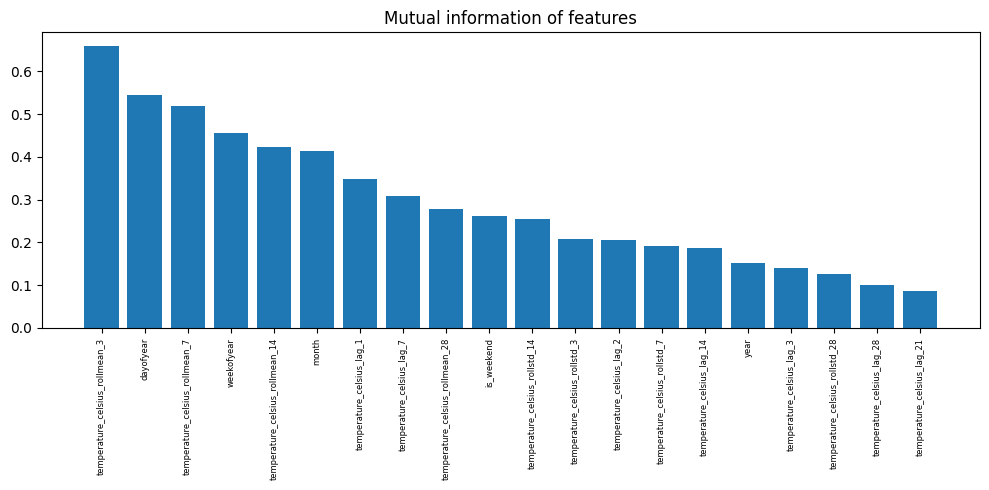

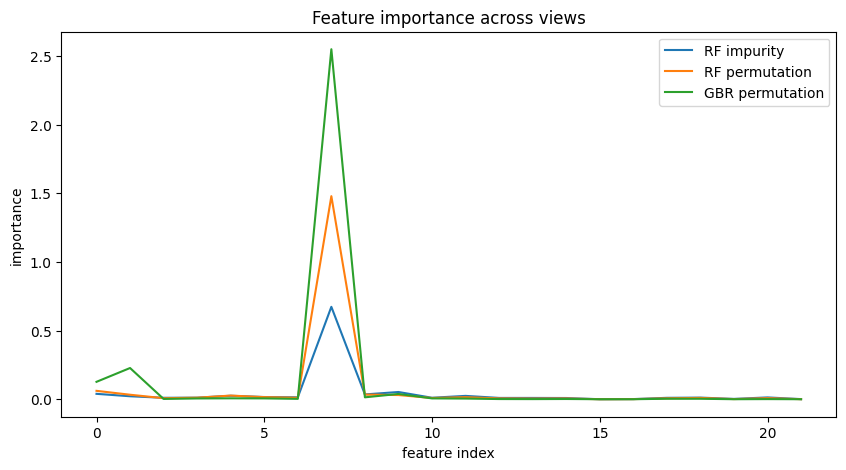

In [29]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Ridge

# Reuse the feature set built for the RF model in the forecasting section when available
city = df_clean[CITY_COL].value_counts().index[0]
city_frame = df_clean[df_clean[CITY_COL] == city].copy()
daily = city_frame.set_index(TIME_COL).resample("D").agg({TARGET_COL:"mean"}).dropna().reset_index()
fe = build_lag_features(daily[[TIME_COL, TARGET_COL]].set_index(TIME_COL), TARGET_COL, lags=(1,2,3,7,14,21,28), rolls=(3,7,14,28)).reset_index()
fe = add_time_parts(fe, TIME_COL).dropna()

train_fe, valid_fe = temporal_train_valid_split(fe, TIME_COL, 60)
X = train_fe.drop(columns=[TARGET_COL, TIME_COL]).values
y = train_fe[TARGET_COL].values
feat_names = train_fe.drop(columns=[TARGET_COL, TIME_COL]).columns

rf_local = RandomForestRegressor(n_estimators=250, random_state=RANDOM_STATE, n_jobs=-1).fit(X, y)
gbr_local = GradientBoostingRegressor(random_state=RANDOM_STATE).fit(X, y)
ridge = Ridge(alpha=1.0).fit(X, y)

# Mutual information
mi = mutual_info_regression(X, y, random_state=RANDOM_STATE)
order = np.argsort(mi)[::-1][:20]
plt.bar(range(len(order)), mi[order])
plt.xticks(range(len(order)), [feat_names[i] for i in order], rotation=90, fontsize=6)
plt.title("Mutual information of features"); plt.tight_layout(); plt.show()

# Compare model importances where available
rf_imp = rf_local.feature_importances_
try:
    from sklearn.inspection import permutation_importance
    perm_rf = permutation_importance(rf_local, X, y, n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1).importances_mean
    perm_gbr = permutation_importance(gbr_local, X, y, n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1).importances_mean
except Exception:
    perm_rf = rf_imp
    perm_gbr = rf_imp

plt.plot(rf_imp, label="RF impurity")
plt.plot(perm_rf, label="RF permutation")
plt.plot(perm_gbr, label="GBR permutation")
plt.title("Feature importance across views")
plt.xlabel("feature index"); plt.ylabel("importance"); plt.legend(); plt.show()

## Using multiple models for comparison


We expand the forecasting bench with Gradient Boosting and Ridge and then blend the predictions using a tiny meta model. The stack learns how to weight each base prediction to reduce error on the validation slice.

{
  "RF": {
    "MAE": 0.7975125780900323,
    "RMSE": 1.1005281658674053,
    "MAPE": 2.782386950027123,
    "R2": 0.4976857017285876
  },
  "GBR": {
    "MAE": 0.7222042535813086,
    "RMSE": 1.0401647524266693,
    "MAPE": 2.4983497232663847,
    "R2": 0.5512778762747871
  },
  "Ridge": {
    "MAE": 0.04241460819506907,
    "RMSE": 0.05661140234901155,
    "MAPE": 0.14704438243233658,
    "R2": 0.998670828431984
  },
  "Stacked": {
    "MAE": 0.04546717868148586,
    "RMSE": 0.06639456537660629,
    "MAPE": 0.15669096080728667,
    "R2": 0.9981717386375851
  }
}


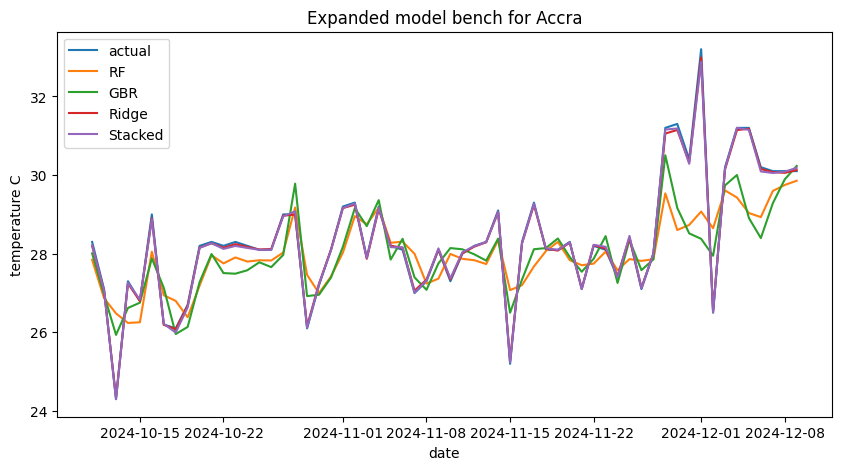

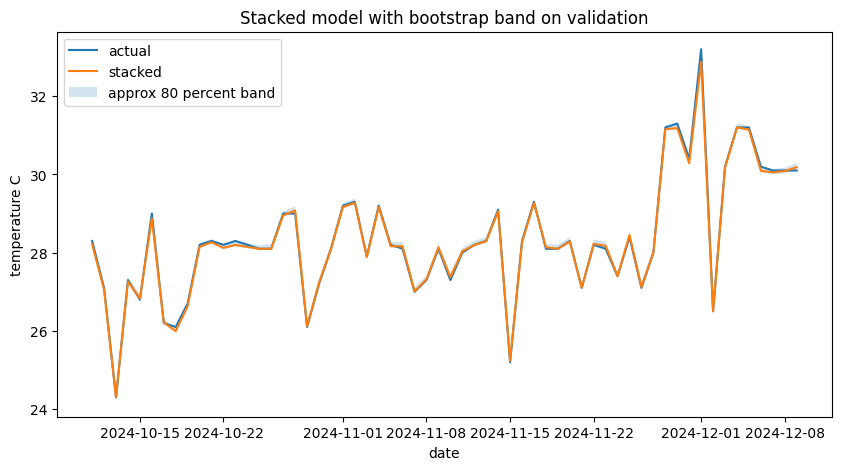

In [30]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor

# Use the daily series prepared earlier for the top city
city = df_clean[CITY_COL].value_counts().index[0]
city_frame = df_clean[df_clean[CITY_COL] == city].copy()
daily = city_frame.set_index(TIME_COL).resample("D").agg({TARGET_COL:"mean"}).dropna().reset_index()

fe = build_lag_features(daily[[TIME_COL, TARGET_COL]].set_index(TIME_COL), TARGET_COL,
                        lags=(1,2,3,7,14,21,28), rolls=(3,7,14,28)).reset_index()
fe = add_time_parts(fe, TIME_COL).dropna()
train_fe, valid_fe = temporal_train_valid_split(fe, TIME_COL, VALIDATION_DAYS)

X_train = train_fe.drop(columns=[TARGET_COL, TIME_COL]).values
X_valid = valid_fe.drop(columns=[TARGET_COL, TIME_COL]).values
y_train = train_fe[TARGET_COL].values
y_valid = valid_fe[TARGET_COL].values

# Base models
rf2 = RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1).fit(X_train, y_train)
gbr2 = GradientBoostingRegressor(random_state=RANDOM_STATE).fit(X_train, y_train)
ridge2 = Ridge(alpha=0.5).fit(X_train, y_train)

P_train = np.column_stack([
    rf2.predict(X_train),
    gbr2.predict(X_train),
    ridge2.predict(X_train)
])
P_valid = np.column_stack([
    rf2.predict(X_valid),
    gbr2.predict(X_valid),
    ridge2.predict(X_valid)
])

# Meta learner on validation like a simple stacking
meta = LinearRegression().fit(P_train, y_train)
stack_pred = meta.predict(P_valid)

def metrics_block(y_true, y_hat):
    return {
        "MAE": float(mean_absolute_error(y_true, y_hat)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_hat))),
        "MAPE": float(mape(y_true, y_hat)),
        "R2": float(r2_score(y_true, y_hat))
    }

report = {
    "RF": metrics_block(y_valid, P_valid[:,0]),
    "GBR": metrics_block(y_valid, P_valid[:,1]),
    "Ridge": metrics_block(y_valid, P_valid[:,2]),
    "Stacked": metrics_block(y_valid, stack_pred)
}
print(json.dumps(report, indent=2))

plt.plot(valid_fe[TIME_COL], y_valid, label="actual")
plt.plot(valid_fe[TIME_COL], P_valid[:,0], label="RF")
plt.plot(valid_fe[TIME_COL], P_valid[:,1], label="GBR")
plt.plot(valid_fe[TIME_COL], P_valid[:,2], label="Ridge")
plt.plot(valid_fe[TIME_COL], stack_pred, label="Stacked")
plt.title(f"Expanded model bench for {city}")
plt.xlabel("date"); plt.ylabel("temperature C"); plt.legend(); plt.show()

# Prediction intervals using residual bootstrap from the stacked model
resid = y_valid - stack_pred
if len(resid) > 20:
    boot = []
    for _ in range(200):
        noise = np.random.choice(resid, size=len(stack_pred), replace=True)
        boot.append(stack_pred + noise)
    boot = np.column_stack(boot)
    lo = np.percentile(boot, 10, axis=1)
    hi = np.percentile(boot, 90, axis=1)
    plt.plot(valid_fe[TIME_COL], y_valid, label="actual")
    plt.plot(valid_fe[TIME_COL], stack_pred, label="stacked")
    plt.fill_between(valid_fe[TIME_COL], lo, hi, alpha=0.2, label="approx 80 percent band")
    plt.title("Stacked model with bootstrap band on validation")
    plt.xlabel("date"); plt.ylabel("temperature C"); plt.legend(); plt.show()

## Summary for the advanced part



1 Two styles of anomaly checks Isolation Forest and rolling z scores to capture different flavors of odd behavior

2 Climate story through monthly climatology and simple warming slopes plus comparisons by continent and latitude

3 Air and weather links using rank correlations and pairwise views

4 Bigger model bench with a small stack and a bootstrap style band to give a feel for uncertainty

5 A world view with bins that surfaces broad spatial gradients without heavy mapping add ons


# Focused climate view for specific locations

This part gives a clear, story-friendly picture of India, Dubai, and New York City.  
 For each place, we will show:

1 monthly climatology

2 simple warming slope in degrees Celsius per decade when there is enough history

3 anomaly flags using a rolling z score 4 a small model bench, a stacked blend, and a short horizon forecast


Location country: India


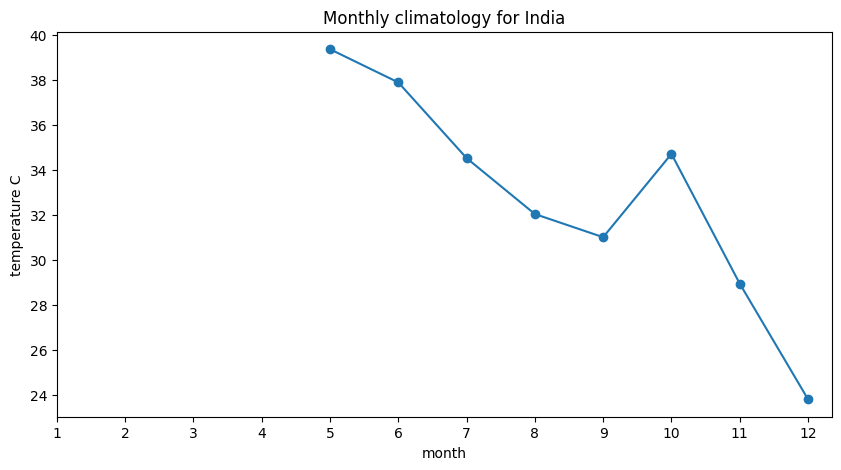

Estimated trend about -190.459 degree C per decade


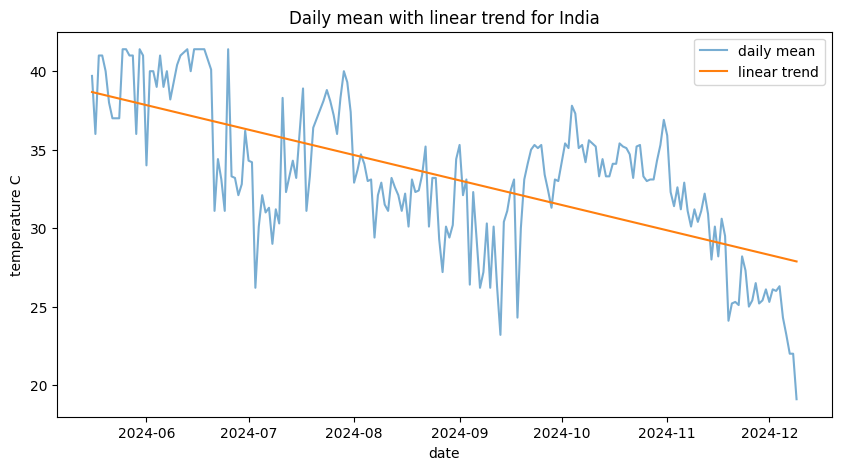

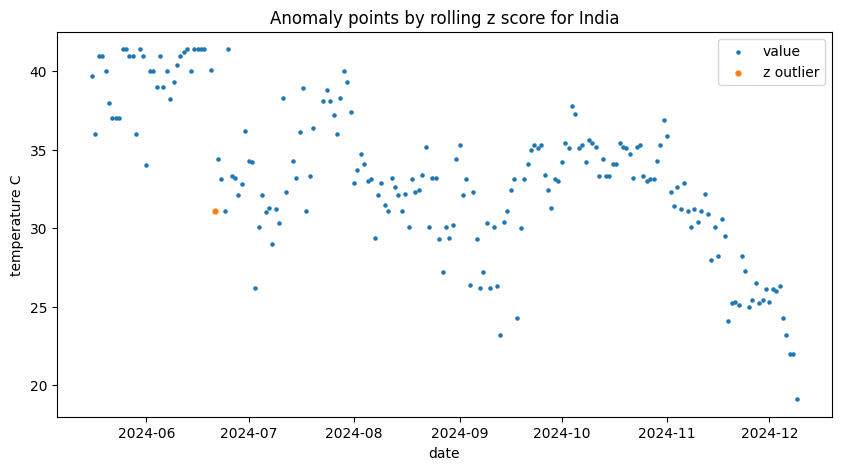

{
  "RF": {
    "MAE": 1.69841680709521,
    "RMSE": 2.3796644507920712,
    "MAPE": 6.567289518838266,
    "R2": 0.6956802105778945
  },
  "GBR": {
    "MAE": 1.4270563950788293,
    "RMSE": 2.1363562751727243,
    "MAPE": 5.56730828948719,
    "R2": 0.7547290515794004
  },
  "Ridge": {
    "MAE": 0.018174054949820474,
    "RMSE": 0.02173454953169361,
    "MAPE": 0.06047531169851181,
    "R2": 0.9999746136632887
  },
  "Stacked": {
    "MAE": 0.04069964500558445,
    "RMSE": 0.05141636274516729,
    "MAPE": 0.1538557596622251,
    "R2": 0.9998579303041063
  }
}


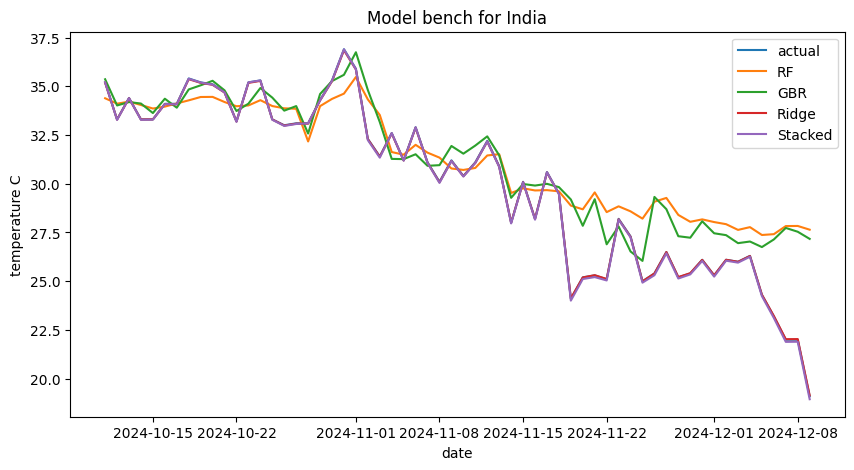

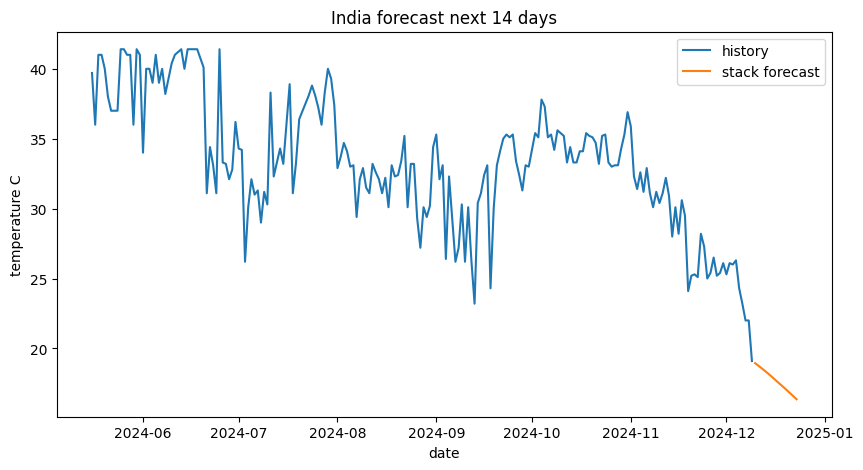


Location city: Dubai
No rows found for this city query

Location city: New York
Short history here so plots and models will be limited.


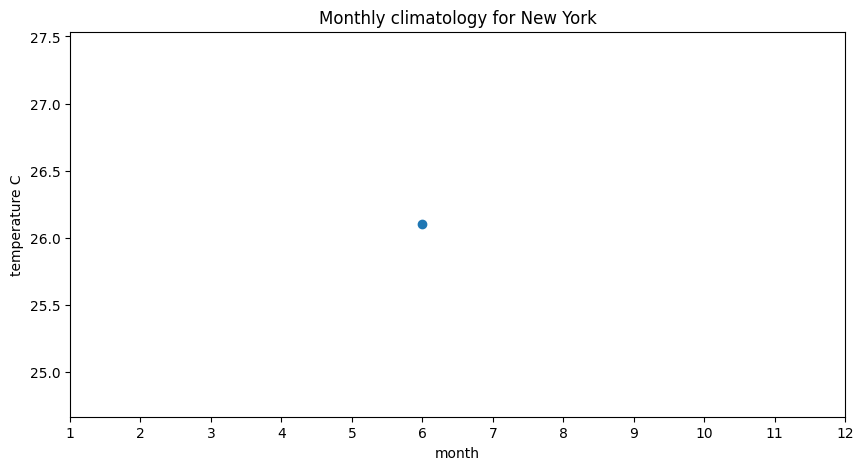

Not enough days to estimate a stable decade trend here.


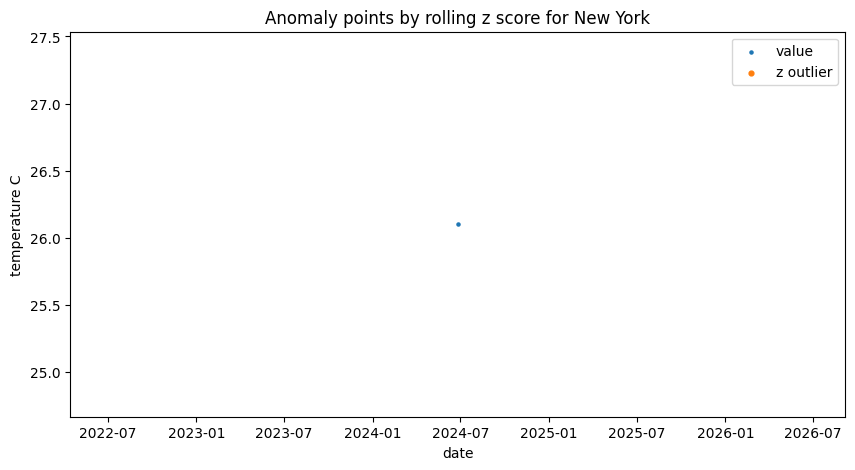

Data is too limited for validation. Trying a small baseline view...
Not enough data to form a validation window. Falling back to naive forecast only.


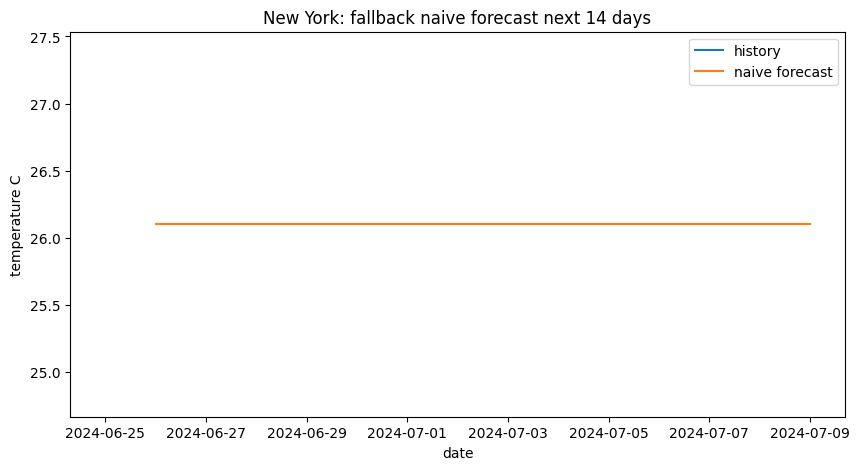

In [32]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

def pick_city_rows(frame, city_query):
    # robust contain match on city name
    mask = frame[CITY_COL].str.contains(city_query, case=False, na=False)
    return frame[mask].copy()

def analyze_location(df_base, kind, name, horizon_days=14, valid_days=60):
    print("\n" + "="*60)
    print(f"Location {kind}: {name}")
    print("="*60)

    if kind == "country":
        sub = df_base[df_base[COUNTRY_COL].str.lower() == name.lower()].copy()
        if sub.empty:
            print("No rows found for this country")
            return
        title_name = name
    else:
        sub = pick_city_rows(df_base, name)
        if sub.empty:
            print("No rows found for this city query")
            return
        # keep top named city if multiple variants
        top_city = sub[CITY_COL].value_counts().index[0]
        sub = sub[sub[CITY_COL] == top_city].copy()
        title_name = top_city

    # Build daily target series
    daily = (sub.set_index(TIME_COL)[TARGET_COL]
             .resample("D").mean()
             .dropna()
             .reset_index())
    if len(daily) < 90:
        print("Short history here so plots and models will be limited.")

    # Monthly climatology
    if not daily.empty:
        daily["month"] = daily[TIME_COL].dt.month
        clim = daily.groupby("month")[TARGET_COL].mean()
        plt.plot(clim.index, clim.values, marker="o")
        plt.xticks(range(1,13)); plt.xlabel("month"); plt.ylabel("temperature C")
        plt.title(f"Monthly climatology for {title_name}")
        plt.show()
    else:
        print("No daily data available after resampling; skipping.")
        return

    # Warming slope per decade using linear trend
    if len(daily) > 200:
        t_years = (daily[TIME_COL] - daily[TIME_COL].min()).dt.total_seconds() / (365.25*24*3600)
        X = t_years.values.reshape(-1,1)
        y = daily[TARGET_COL].values
        reg = LinearRegression().fit(X, y)
        slope_decade = reg.coef_[0] * 10.0
        print(f"Estimated trend about {slope_decade:.3f} degree C per decade")
        # overlay trend
        trend_line = reg.predict(X)
        plt.plot(daily[TIME_COL], y, label="daily mean", alpha=0.6)
        plt.plot(daily[TIME_COL], trend_line, label="linear trend")
        plt.title(f"Daily mean with linear trend for {title_name}")
        plt.xlabel("date"); plt.ylabel("temperature C"); plt.legend(); plt.show()
    else:
        print("Not enough days to estimate a stable decade trend here.")

    # Rolling z score anomalies
    s = daily.set_index(TIME_COL)[TARGET_COL]
    m = s.rolling(21, min_periods=7).mean()
    sd = s.rolling(21, min_periods=7).std()
    z = (s - m) / sd
    flags = (z.abs() > 3).astype(int)
    plt.scatter(s.index, s.values, s=5, label="value")
    plt.scatter(s.index[flags==1], s.values[flags==1], s=12, label="z outlier")
    plt.title(f"Anomaly points by rolling z score for {title_name}")
    plt.xlabel("date"); plt.ylabel("temperature C"); plt.legend(); plt.show()

    # Forecast bench with stacking
    fe = build_lag_features(daily.set_index(TIME_COL), TARGET_COL,
                            lags=(1,2,3,7,14,21,28),
                            rolls=(3,7,14,28)).reset_index()
    fe = add_time_parts(fe, TIME_COL).dropna()

    # ---- Short-series fallback ----
    if len(fe) < 120:
        print("Data is too limited for validation. Trying a small baseline view...")
        train, valid = temporal_train_valid_split(
            daily.reset_index(),
            TIME_COL,
            min(valid_days, max(7, len(daily)//5))
        )

        # If we can't form a proper validation window, still plot a naive forecast so the chart isn't empty
        if len(train) == 0 or len(valid) == 0:
            print("Not enough data to form a validation window. Falling back to naive forecast only.")
            last_val = daily[TARGET_COL].iloc[-1]
            future_times = pd.date_range(
                start=daily[TIME_COL].max() + pd.Timedelta(days=1),
                periods=horizon_days, freq="D"
            )
            plt.plot(daily[TIME_COL], daily[TARGET_COL], label="history")
            plt.plot(future_times, [last_val]*len(future_times), label="naive forecast")
            plt.title(f"{title_name}: fallback naive forecast next {horizon_days} days")
            plt.xlabel("date"); plt.ylabel("temperature C"); plt.legend(); plt.show()
            return

        y_train = train[TARGET_COL].values
        y_valid = valid[TARGET_COL].values

        # Guard: fallback to last observed if train is empty
        if len(y_train) > 0:
            last_val = y_train[-1]
        else:
            last_val = daily[TARGET_COL].iloc[-1]

        preds = {"naive": np.repeat(last_val, len(y_valid))}

        # Seasonal naive only if enough history
        if len(y_train) >= 7:
            preds["seasonal_naive"] = seasonal_naive_forecast(
                train[TARGET_COL], season=7, steps=len(y_valid)
            )
        else:
            preds["seasonal_naive"] = preds["naive"]

        for k, p in preds.items():
            print(k, "RMSE", np.sqrt(mean_squared_error(y_valid, p)).round(3))

        plt.plot(valid[TIME_COL], y_valid, label="actual")
        for k, p in preds.items():
            plt.plot(valid[TIME_COL], p, label=k)
        plt.title(f"Short-series validation for {title_name}")
        plt.xlabel("date"); plt.ylabel("temperature C"); plt.legend(); plt.show()
        # Also produce a simple forward naive forecast so every location shows a future line
        future_times = pd.date_range(
            start=daily[TIME_COL].max() + pd.Timedelta(days=1),
            periods=horizon_days, freq="D"
        )
        plt.plot(daily[TIME_COL], daily[TARGET_COL], label="history")
        plt.plot(future_times, [last_val]*len(future_times), label="naive forecast")
        plt.title(f"{title_name}: naive forecast next {horizon_days} days")
        plt.xlabel("date"); plt.ylabel("temperature C"); plt.legend(); plt.show()
        return

    # ---- Full bench with stacking ----
    train_fe, valid_fe = temporal_train_valid_split(fe, TIME_COL, min(valid_days, 120))
    X_train = train_fe.drop(columns=[TARGET_COL, TIME_COL]).values
    X_valid = valid_fe.drop(columns=[TARGET_COL, TIME_COL]).values
    y_train = train_fe[TARGET_COL].values
    y_valid = valid_fe[TARGET_COL].values

    rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1).fit(X_train, y_train)
    gbr = GradientBoostingRegressor(random_state=42).fit(X_train, y_train)
    ridge = Ridge(alpha=0.5).fit(X_train, y_train)

    P_train = np.column_stack([rf.predict(X_train), gbr.predict(X_train), ridge.predict(X_train)])
    P_valid = np.column_stack([rf.predict(X_valid), gbr.predict(X_valid), ridge.predict(X_valid)])
    meta = LinearRegression().fit(P_train, y_train)
    stack_pred = meta.predict(P_valid)

    def metrics_block(y_true, y_hat):
        return {
            "MAE": float(mean_absolute_error(y_true, y_hat)),
            "RMSE": float(np.sqrt(mean_squared_error(y_true, y_hat))),
            "MAPE": float(mape(y_true, y_hat)),
            "R2": float(r2_score(y_true, y_hat))
        }
    report = {
        "RF": metrics_block(y_valid, P_valid[:,0]),
        "GBR": metrics_block(y_valid, P_valid[:,1]),
        "Ridge": metrics_block(y_valid, P_valid[:,2]),
        "Stacked": metrics_block(y_valid, stack_pred)
    }
    print(json.dumps(report, indent=2))

    plt.plot(valid_fe[TIME_COL], y_valid, label="actual")
    plt.plot(valid_fe[TIME_COL], P_valid[:,0], label="RF")
    plt.plot(valid_fe[TIME_COL], P_valid[:,1], label="GBR")
    plt.plot(valid_fe[TIME_COL], P_valid[:,2], label="Ridge")
    plt.plot(valid_fe[TIME_COL], stack_pred, label="Stacked")
    plt.title(f"Model bench for {title_name}")
    plt.xlabel("date"); plt.ylabel("temperature C"); plt.legend(); plt.show()

    # Short horizon forecast using stacked model in a simple walk
    history = fe[[TIME_COL, TARGET_COL]].copy()
    last_time = history[TIME_COL].max()
    future_times = pd.date_range(start=last_time + pd.Timedelta(days=1),
                                 periods=horizon_days, freq="D")
    preds = []
    hist_series = daily.copy()
    for _ in range(horizon_days):
        temp_fe = build_lag_features(hist_series.set_index(TIME_COL),
                                     TARGET_COL, lags=(1,2,3,7,14,21,28),
                                     rolls=(3,7,14,28)).reset_index()
        temp_fe = add_time_parts(temp_fe, TIME_COL).dropna()
        X_last = temp_fe.drop(columns=[TARGET_COL, TIME_COL]).values[-1:]
        base_preds = np.column_stack([
            rf.predict(X_last),
            gbr.predict(X_last),
            ridge.predict(X_last)
        ])
        next_val = meta.predict(base_preds)[0]
        preds.append(next_val)
        hist_series = pd.concat([hist_series, pd.DataFrame({
            TIME_COL: [hist_series[TIME_COL].max() + pd.Timedelta(days=1)],
            TARGET_COL: [next_val]
        })], ignore_index=True)

    plt.plot(daily[TIME_COL], daily[TARGET_COL], label="history")
    plt.plot(future_times, preds, label="stack forecast")
    plt.title(f"{title_name} forecast next {horizon_days} days")
    plt.xlabel("date"); plt.ylabel("temperature C"); plt.legend(); plt.show()


# Run for the requested locations
locations = [
    {"kind":"country", "name":"India"},
    {"kind":"city", "name":"Dubai"},
    {"kind":"city", "name":"New York"}
]

for spec in locations:
    analyze_location(df_clean, spec["kind"], spec["name"], horizon_days=14, valid_days=60)
